# Import environment

In [31]:
import os
from datetime import datetime
import pathlib


if 'main_dir' in globals():
    os.chdir(main_dir)

import pandas as pd
from utils.load_config import (
    load_exp_config, 
    get_value_from_fields, 
    )

from utils.load_data import (
    get_df_from_datetime_range
    )

from utils.plotting import (
    STICK_SIZE,
    plot_cost_ic_learning_curve_mod,
    plot_cost_median_top_5_learning_curve,
    plot_accum_cost_ic,
    plot_accum_cost_median,
    plot_chosen_best_checkpoint,
    plot_distance_goal_hist,
    plot_distance_goal_comhist
    )

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# plt.style.use("tableau-colorblind10")
plt.style.use("seaborn-v0_8-whitegrid")

from regelum.objective import RunningObjective
from regelum.model import ModelQuadLin
import numpy as np


if os.getcwd().endswith("notebooks"):
    main_dir = os.getcwd()
    os.chdir("..")

%matplotlib inline

In [32]:
try:
    from src.objective import ThreeWheeledRobotCostWithSpot
except:
    from src.objective import ThreeWheeledRobotCostWithSpot

# Setup Objective function for re-calculation

In [33]:

objective_function = RunningObjective(ModelQuadLin(
    weights= [2, 10, 0, 0, 0],
    quad_matrix_type="diagonal",
    is_with_linear_terms=False,
))

objective_function = ThreeWheeledRobotCostWithSpot(
    quadratic_model=ModelQuadLin(
        weights= [100, 100, 0, 0, 0],
        quad_matrix_type="diagonal",
        is_with_linear_terms=False),
        spot_gain=100,
        spot_x_center=-0.5,
        spot_y_center=-0.5,
        spot_std=0.2,
    )


def get_sampling_time(exp_path):
    config = load_exp_config(exp_path)

    sampling_time = config['scenario']['sampling_time']
    if "$" in sampling_time:
        correct_fields = sampling_time.strip("\{\}$").split(".")
        sampling_time = get_value_from_fields(config, correct_fields)

    return sampling_time

    

In [34]:

observation = np.array([[1, 1, 0.01]])
actions = np.array([[1, 1]])
objective_function(observation, actions)

200.0

## Plot objective

In [35]:
def get_cost_map(x_lim, y_lim):
    X = np.arange(x_lim[0], x_lim[1], 0.01)
    Y = np.arange(y_lim[0], y_lim[1], 0.01)

    X, Y = np.meshgrid(X, Y)
    Z = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z.append(objective_function(observation=np.array([[X[i, j], Y[i, j], 0]]),
                                        action=np.array([[0, 0]])))

    Z = np.array(Z).reshape((X.shape[0], X.shape[1]))
    
    return X, Y, Z
X, Y, Z = get_cost_map([-1.7, 0.3], [-1.7, 0.3])

# Plotting

## Get data from experiments

In [36]:
DECAY_RATE = 1

start_datetime_str = "2024-08-30 10-58-48"
end_datetime_str = "2024-08-30 13-30-59"
calf_df = get_df_from_datetime_range(start_datetime_str, 
                                        end_datetime_str, 
                                        objective_function=objective_function,
                                        decay_rate=DECAY_RATE)


## Define colors

In [37]:
color_selection = {
    "CALF": ["lightblue", "tab:blue"],
}

## Plot learning curves

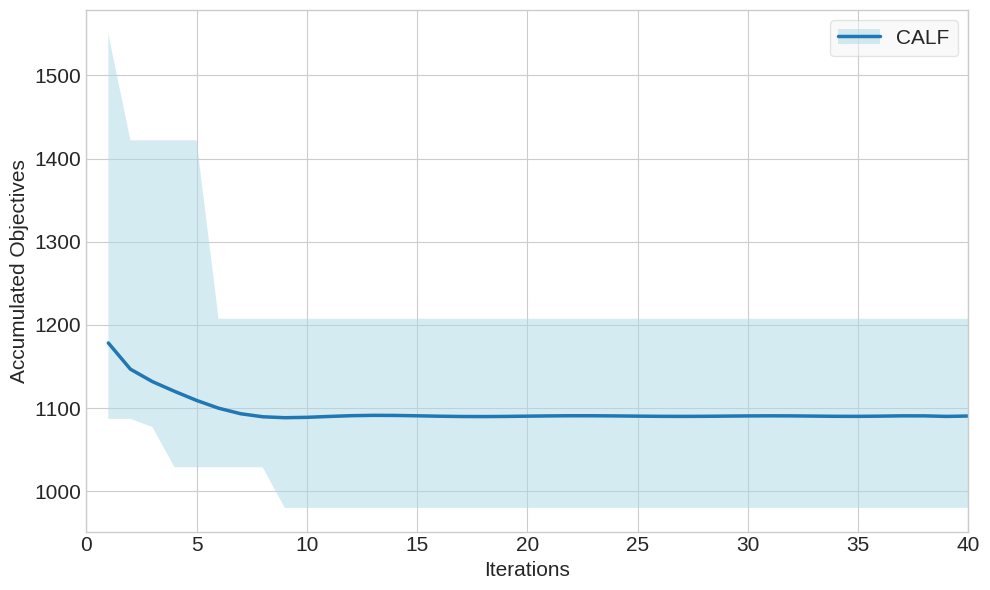

In [38]:
# %matplotlib inline
plt.clf()

MEDIUM_SIZE = 10
BIG_SIZE = 15
plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=BIG_SIZE)
plt.rc('xtick', labelsize=BIG_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIG_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIG_SIZE)

plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')
plt.style.use("seaborn-v0_8-whitegrid")

p3 = plot_cost_ic_learning_curve_mod(calf_df, ax, color=color_selection["CALF"][0], use_interpolate=True)
p4 = plot_cost_median_top_5_learning_curve(calf_df, ax, color=color_selection["CALF"][1])

legend_info = {
    "CALF": (p3, p4),
}

legend = ax.legend(legend_info.values(), 
                   legend_info.keys(),
                   facecolor='whitesmoke', 
                   framealpha=0.5)
legend.set_frame_on(True)

ax.set_xlim(0, 40)
plt.tight_layout()
fig.savefig("media/report_learning_curves.svg", 
            facecolor='w',
            bbox_inches = 'tight',
            pad_inches = 0)

## Plot accumulated cost over time

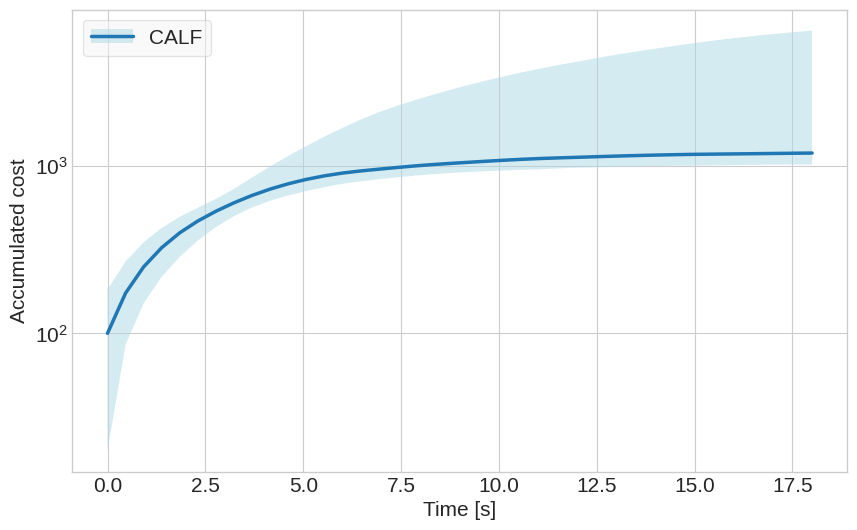

In [39]:
# %matplotlib inline

plt.clf()
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')
# ax.patch.set_facecolor('white')
plt.style.use("seaborn-v0_8-whitegrid")

p3 = plot_accum_cost_ic(calf_df, ax, color=color_selection["CALF"][0])
p4 = plot_accum_cost_median(calf_df, ax, color=color_selection["CALF"][1])

legend_info = {
    "CALF": (p3, p4),
}

legend = ax.legend(legend_info.values(), 
                   legend_info.keys(),
                   facecolor='whitesmoke', 
                   framealpha=0.5)
legend.set_frame_on(True)

ax.set_yscale("log")
# ax.set_xlim(0, 40)

ax.set_ylabel("Accumulated cost")

ax.tick_params(axis='both', labelsize=STICK_SIZE)

fig.savefig("media/report_acc_costs.svg", 
            facecolor="white",
            bbox_inches = 'tight',
            pad_inches = 0)
# plt.show()
# frame

# Plot trajectories

1. Find the best checkpoint of CALF, SARSA_m, PPO
2. Run the best checkpoints with 25 seeds
3. Plot each of them in 1 subplot and with Nominal, 3x MPC

## Find the best CALF and Control signal

/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-30/13-30-59/0/.callbacks/HistoricalDataCallback/observations_actions_it_00009.h5


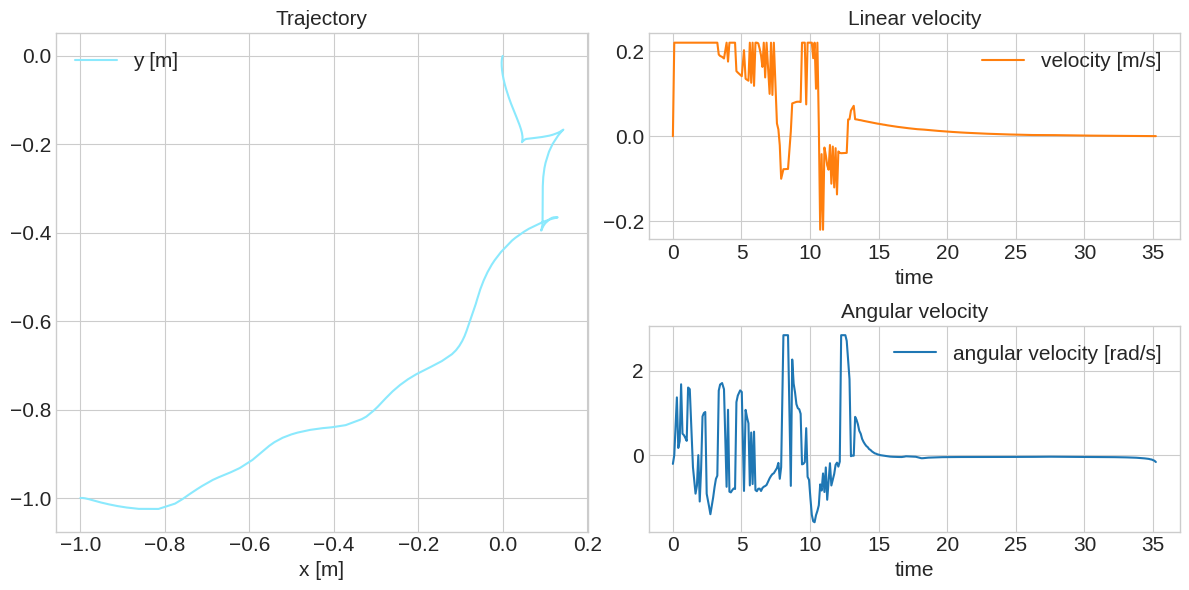

In [69]:
def find_best_exp_from_df(df, radius=0.15):
    df["goal_err"] = df.apply(lambda x: np.linalg.norm([x["x [m]"], x["y [m]"]]), axis=1)

    group_df = df.groupby(["absolute_path"]).last()
    group_df = group_df[group_df.goal_err < radius]

    index = group_df[group_df.accumulative_objective == group_df.accumulative_objective.min()].index
    best_exp = df.query(f"absolute_path == \"{index[0]}\"")

    return best_exp, index[0]

best_calf_df, best_calf_path = find_best_exp_from_df(calf_df)

print(best_calf_path)


plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
best_calf_df.plot(x="x [m]", y="y [m]", title="Trajectory", ax=ax1)

ax2 = plt.subplot(2, 2, 2)
best_calf_df.plot(x="time", 
                  y="velocity [m/s]", ax=ax2, color="tab:orange", title="Linear velocity")

ax3 = plt.subplot(2, 2, 4)
best_calf_df.plot(x="time", 
                  y="angular velocity [rad/s]", ax=ax3, color="tab:blue", title="Angular velocity")
plt.tight_layout()

## Load Runs with best checkpoints

In [25]:
# CALF with spot penalty 1e2
start_datetime_str = "2024-08-30 09-19-44"
end_datetime_str = "2024-08-30 09-38-13"
best_calf_df = get_df_from_datetime_range(start_datetime_str, 
                                          end_datetime_str,
                                          objective_function=objective_function, 
                                          decay_rate=DECAY_RATE)


## Plotting trajectories functions

## Plotting trajectories

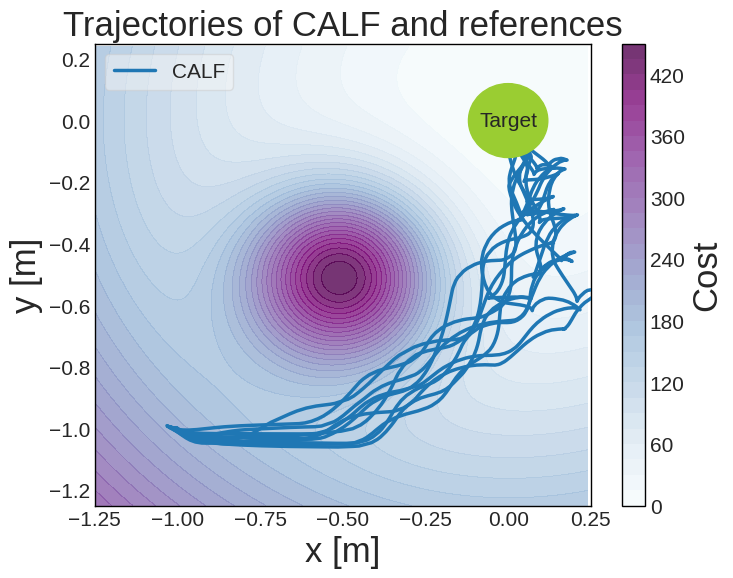

In [26]:
group_df = best_calf_df.groupby(["absolute_path"]).last()
top_10_abs_path = group_df.sort_values(by="accumulative_objective").iloc[:10, :].index
top_10_df = best_calf_df[best_calf_df["absolute_path"].isin(top_10_abs_path)]
plot_chosen_best_checkpoint(top_10_df, "CALF", 
                            color_selection["CALF"][1], 
                            linestyle="solid", 
                            target_r=0.12,
                            get_cost_map_func=get_cost_map)

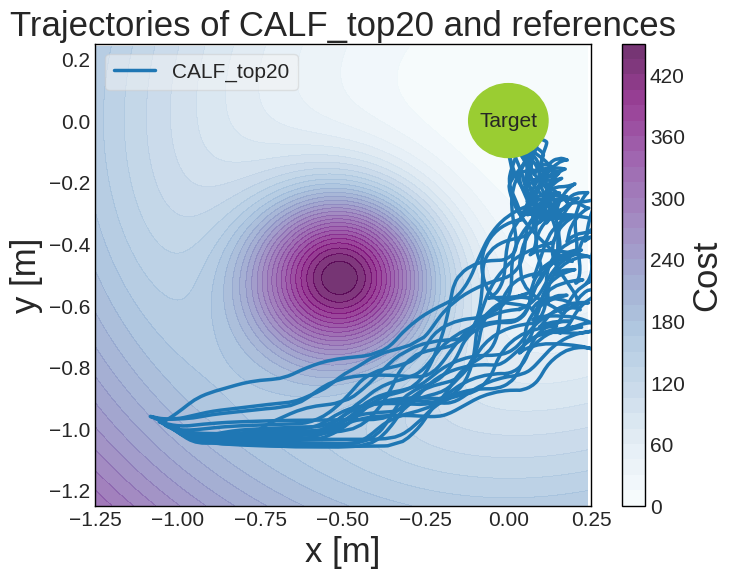

In [27]:
N_TOP=20
group_df = best_calf_df.groupby(["absolute_path"]).last()
top_abs_path = group_df.sort_values(by="accumulative_objective").iloc[:N_TOP, :].index
top_df = best_calf_df[best_calf_df["absolute_path"].isin(top_abs_path)]
plot_chosen_best_checkpoint(top_df, f"CALF_top{N_TOP}", 
                            color_selection["CALF"][1], 
                            linestyle="solid", 
                            target_r=0.12,
                            get_cost_map_func=get_cost_map)

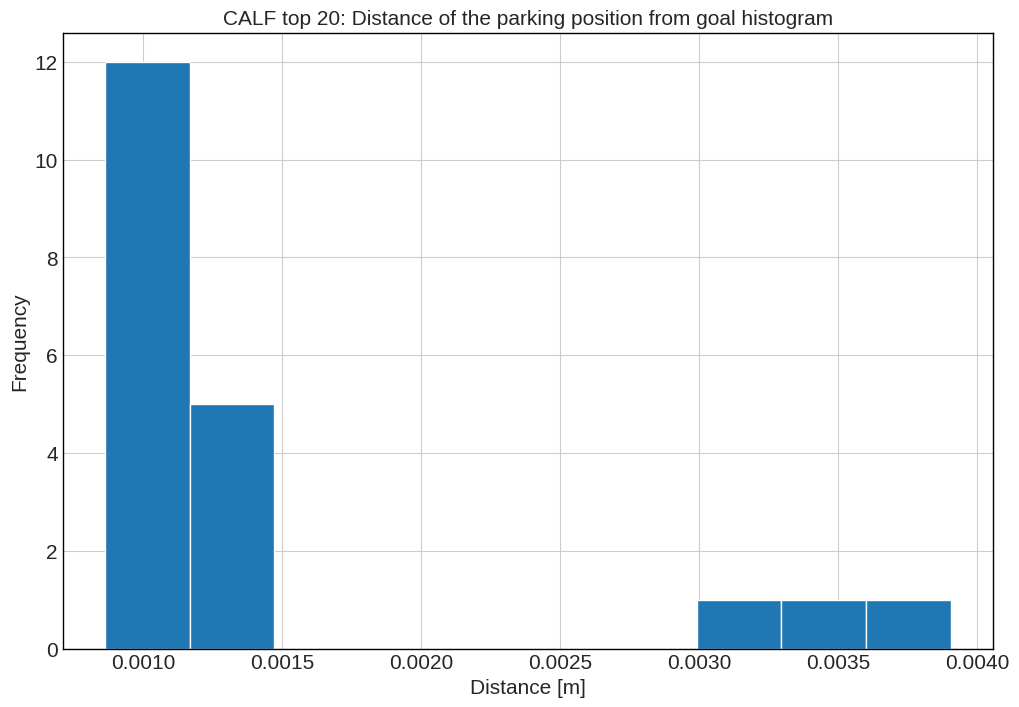

In [28]:
   
plot_distance_goal_hist(best_calf_df, "CALF", color_selection["CALF"][1], n_top=20)